In [1]:
# Michael Fousianiss & Zacharias Thorell
# Assignment 3
# Pizza?
# Adapted from: https://www.tensorflow.org/tutorials/images/classification
# This file is not meant for you to run, only to showcase how we have built our system.
# To test the system please see application.ipynb.

In [2]:
#Necessary imports.
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# Directory of the trinaing data, consisting of 5517 images of 'other' and 9213 images of 'pizza'.
data_dir = pathlib.Path('images/training')

In [4]:
# Creating a training dataset.
# 80% training, 20% validation.
batch_size = 32
img_height = 180
img_width = 180

training_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 14730 files belonging to 2 classes.
Using 11784 files for training.


In [5]:
# Creating a validation dataset.
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split = 0.2,
  subset = 'validation',
  seed = 123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 14730 files belonging to 2 classes.
Using 2946 files for validation.


In [6]:
# Print the class names.
# other - an array of food stuff.
# pizza - pizza.
class_names = training_dataset.class_names
print(class_names)

['other', 'pizza']


In [7]:
# Configure for better performance.
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size = AUTOTUNE)

In [8]:
# Creating the model.
num_classes = 2

# 1st Model.

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [9]:
epochs = 10
save_freq = epochs

model1_path = 'models/model1/model1.ckpt'
model1_callback = tf.keras.callbacks.ModelCheckpoint(
  model1_path, 
  save_weights_only = True, 
  verbose = 0, 
  save_freq = save_freq
  )

model.save_weights(model1_path)

history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = epochs,
  callbacks = [model1_callback]
)

Epoch 1/10
369/369 [==============================] - 136s 317ms/step - loss: 0.3342 - accuracy: 0.8548 - val_loss: 0.2813 - val_accuracy: 0.8900
Epoch 2/10
369/369 [==============================] - 116s 314ms/step - loss: 0.1839 - accuracy: 0.9306 - val_loss: 0.1676 - val_accuracy: 0.9379
Epoch 3/10
369/369 [==============================] - 116s 313ms/step - loss: 0.1443 - accuracy: 0.9447 - val_loss: 0.2872 - val_accuracy: 0.8955
Epoch 4/10
369/369 [==============================] - 115s 311ms/step - loss: 0.1098 - accuracy: 0.9589 - val_loss: 0.1755 - val_accuracy: 0.9420
Epoch 5/10
369/369 [==============================] - 115s 311ms/step - loss: 0.0775 - accuracy: 0.9699 - val_loss: 0.1690 - val_accuracy: 0.9433
Epoch 6/10
369/369 [==============================] - 116s 314ms/step - loss: 0.0612 - accuracy: 0.9747 - val_loss: 0.1925 - val_accuracy: 0.9341
Epoch 7/10
369/369 [==============================] - 115s 311ms/step - loss: 0.0350 - accuracy: 0.9877 - val_loss: 0.2267 -

In [10]:
def plot_acc_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

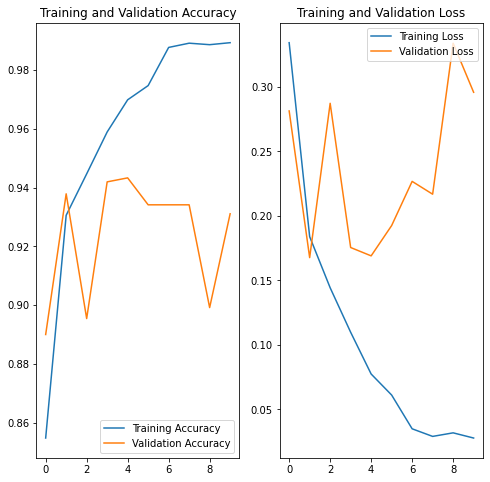

In [11]:
# Plotting the loss and accuracy, as can be seen by the fact that validation accuracy is lower than training accuracy, the model suffers from overfitting on the training data.
plot_acc_loss(history)

In [12]:
def test_unknown_sample(path, model):
    img = tf.keras.utils.load_img(
        path, target_size = (img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [13]:
# Testing with unknown (not used in either training or validation set) example.
test_unknown_sample('images/unknown/real_pizza.jpg', model)    # Real pizza, should be labeled as pizza.
test_unknown_sample('images/unknown/burger.jpg', model)        # Burger, should be labeled as other.
test_unknown_sample('images/unknown/fake_pizza.jpg', model)    # A fake pizza.

This image most likely belongs to pizza with a 100.00 percent confidence.
This image most likely belongs to other with a 99.85 percent confidence.
This image most likely belongs to other with a 99.92 percent confidence.


In [14]:
# Since overfitting was present, lets try and make the model more general by applying transformations (flipping, tilting...) on the dataset.
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# 2nd Model.

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model2_path = 'models/model2/model2.ckpt'
model2_callback = tf.keras.callbacks.ModelCheckpoint(
  model2_path, 
  save_weights_only = True, 
  verbose = 0, 
  save_freq = save_freq
  )

model.save_weights(model2_path)

In [16]:
history = model.fit(
  training_dataset,
  validation_data = validation_dataset,
  epochs = epochs,
  callbacks = [model2_callback]
)

Epoch 1/10
369/369 [==============================] - 129s 348ms/step - loss: 0.2706 - accuracy: 0.8828 - val_loss: 0.9884 - val_accuracy: 0.7512
Epoch 2/10
369/369 [==============================] - 128s 347ms/step - loss: 0.1828 - accuracy: 0.9311 - val_loss: 0.2303 - val_accuracy: 0.9212
Epoch 3/10
369/369 [==============================] - 128s 348ms/step - loss: 0.1686 - accuracy: 0.9346 - val_loss: 0.3088 - val_accuracy: 0.8839
Epoch 4/10
369/369 [==============================] - 128s 348ms/step - loss: 0.1534 - accuracy: 0.9414 - val_loss: 0.4228 - val_accuracy: 0.8734
Epoch 5/10
369/369 [==============================] - 129s 349ms/step - loss: 0.1336 - accuracy: 0.9530 - val_loss: 0.1823 - val_accuracy: 0.9396
Epoch 6/10
369/369 [==============================] - 129s 349ms/step - loss: 0.1206 - accuracy: 0.9546 - val_loss: 0.4681 - val_accuracy: 0.8625
Epoch 7/10
369/369 [==============================] - 128s 348ms/step - loss: 0.1101 - accuracy: 0.9584 - val_loss: 0.1821 -

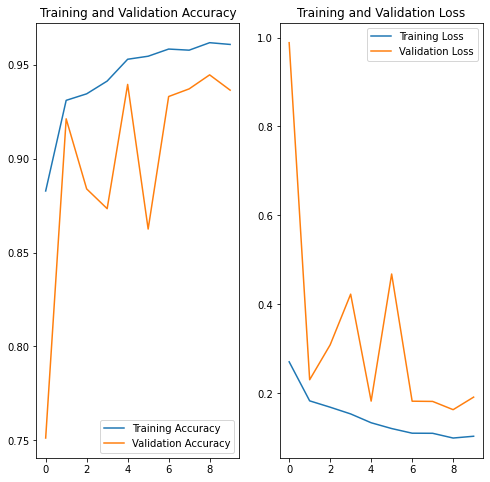

In [17]:
plot_acc_loss(history)

In [18]:
test_unknown_sample('images/unknown/real_pizza.jpg', model)    # Real pizza, should be labeled as pizza.
test_unknown_sample('images/unknown/burger.jpg', model)        # Burger, should be labeled as other.
test_unknown_sample('images/unknown/fake_pizza.jpg', model)    # A fake pizza.

This image most likely belongs to pizza with a 100.00 percent confidence.
This image most likely belongs to other with a 50.86 percent confidence.
This image most likely belongs to pizza with a 80.36 percent confidence.
